# Registration Test

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import ants
import sys

# Custom imports
from src import register, transform_points, utils

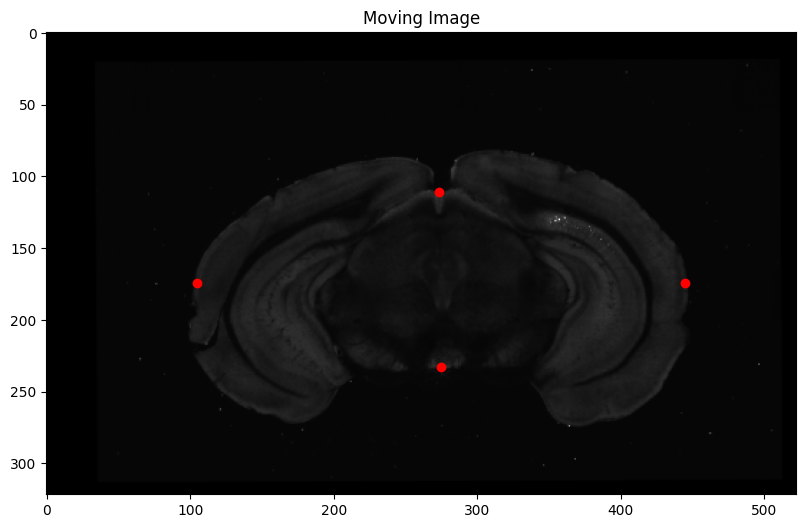

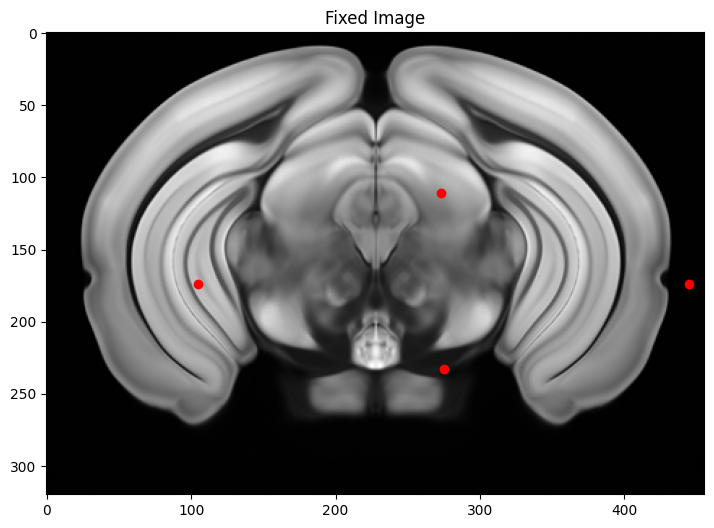

In [2]:
moving_image_path = "data/B0182_brain_25.nii.gz"
fixed_image_path = "../../../CCF_DATA/average_template_25.nii.gz"
output_path = "output/registered_image.nii.gz"
#points = np.array([[150, 185, 278],  # Top
#                   [150, 172, 278],  # Bottom
#                   [150, 174, 262],  # Left
#                   [150, 174, 292]]) # Right
points = np.array([[200, 111, 273],  # Top
                   [200, 233, 275],  # Bottom
                   [200, 174, 105],  # Left
                   [200, 174, 445]]) # Right

idx = 200
fixed_idx = 350

# Load data
moving_image = nib.load(moving_image_path).get_fdata()
fixed_image = nib.load(fixed_image_path).get_fdata()

# Show images
plt.figure(figsize=(12, 6))
plt.imshow(moving_image[idx, :, :], cmap='gray')
for point in points:
    plt.plot(point[2], point[1], 'ro')  # Note: plot(x, y) 
plt.title('Moving Image')
plt.show()

plt.figure(figsize=(12, 6))
plt.imshow(fixed_image[fixed_idx, :, :], cmap='gray')
for point in points:
    plt.plot(point[2], point[1], 'ro')  # Note: plot(x, y) 
plt.title('Fixed Image')
plt.show()

Registering moving image to fixed image...
Registered image saved to output/registered_image.nii.gz
Forward transforms: ['/tmp/tmpcqhxqdd61Warp.nii.gz', '/tmp/tmpcqhxqdd60GenericAffine.mat']


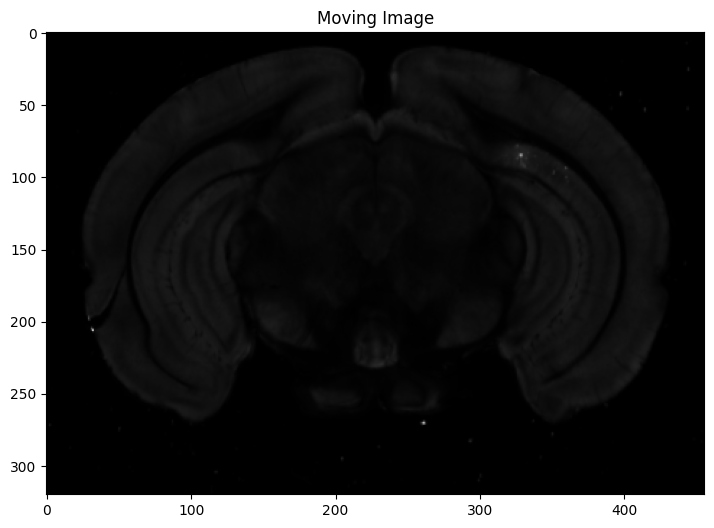

In [ ]:
fwdtransforms, result = register.register_images(moving_image_path, fixed_image_path, output_path)

# Show registered images
registered_image = nib.load(output_path).get_fdata()
plt.figure(figsize=(12, 6))
plt.imshow(registered_image[fixed_idx, :, :], cmap='gray')
plt.title('Registered Image')
plt.show()

In [4]:
output_points_path = "output/transformed_points.npy"

# Apply transform
xyz_points = points[:, ::-1].copy()
#transformed_points = register.apply_transform_to_points(xyz_points, fwdtransforms, fixed_image)

import pandas as pd
df = pd.DataFrame(points, columns=['x', 'y', 'z'])
transformed_points = ants.apply_transforms_to_points(
    dim=3,
    points=df,
    transformlist=fwdtransforms
)
print("Original points:\n", points)
print("Reformatted points:\n", xyz_points)


transformed_points = transformed_points.to_numpy()
print("Transformed points:\n", transformed_points)


transformed_points = transformed_points[:, ::-1]  # Revert to original order for saving
print("Reverted points:\n", transformed_points)

np.save(output_points_path, transformed_points)
print("Transformed points saved.")

Original points:
 [[200 111 273]
 [200 233 275]
 [200 174 105]
 [200 174 445]]
Reformatted points:
 [[273 111 200]
 [275 233 200]
 [105 174 200]
 [445 174 200]]
Transformed points:
 [[171.11772   88.40847  194.84853 ]
 [171.26335  213.25346  202.47101 ]
 [169.11865  164.88226   80.514114]
 [173.29094  140.73555  318.40887 ]]
Reverted points:
 [[194.84853   88.40847  171.11772 ]
 [202.47101  213.25346  171.26335 ]
 [ 80.514114 164.88226  169.11865 ]
 [318.40887  140.73555  173.29094 ]]
Transformed points saved.


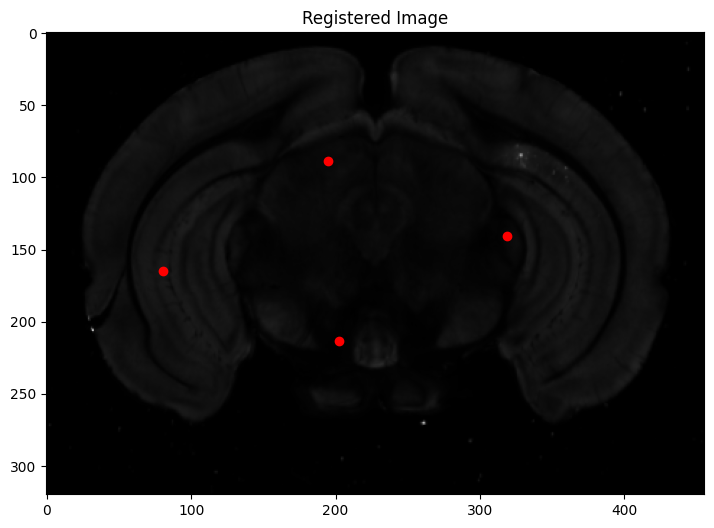

In [24]:
curr_idx = 350

# Show transformed points images
plt.figure(figsize=(12, 6))
plt.imshow(registered_image[curr_idx, :, :], cmap='gray')
#plt.xlim(240, 320)
#plt.ylim(150, 200)
for point in transformed_points[:, ::-1]:
    plt.plot(point[2], point[1], 'ro')  # Note: plot(x, y) 
plt.title('Registered Image')
plt.show()

## Debug

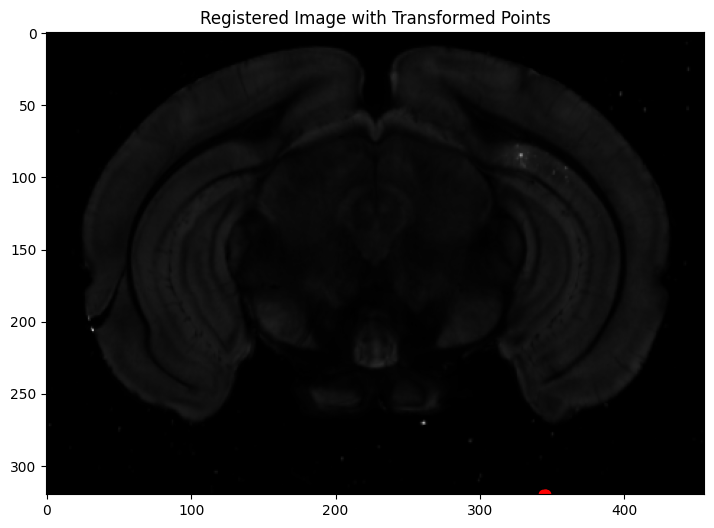

In [30]:
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

# 1. Convert (Z, Y, X) -> (X, Y, Z)
points_xyz_voxel = points[:, ::-1]

# 2. Convert to physical space (mm) using moving image affine
moving_img_nib = nib.load(moving_image_path)
moving_affine = moving_img_nib.affine
points_hom = np.concatenate([points_xyz_voxel, np.ones((points_xyz_voxel.shape[0], 1))], axis=1)
points_phys = (moving_affine @ points_hom.T).T[:, :3]

# 3. Apply ANTs transform in physical space
df_phys = pd.DataFrame(points_phys, columns=['x', 'y', 'z'])
transformed_phys = ants.apply_transforms_to_points(
    dim=3,
    points=df_phys,
    transformlist=fwdtransforms
)

# 4. Convert back to fixed image voxel space
fixed_img_nib = nib.load(fixed_image_path)
fixed_affine = fixed_img_nib.affine
fixed_affine_inv = np.linalg.inv(fixed_affine)
transformed_phys_hom = np.concatenate([transformed_phys[['x', 'y', 'z']].values, np.ones((transformed_phys.shape[0], 1))], axis=1)
transformed_vox_xyz = (fixed_affine_inv @ transformed_phys_hom.T).T[:, :3]
transformed_vox_zyx = transformed_vox_xyz[:, ::-1]

# 5. Round, clip, and plot only in-bounds points
registered_image = nib.load(output_path).get_fdata()
shape = registered_image.shape
transformed_vox_zyx = np.round(transformed_vox_zyx).astype(int)
for i in range(3):
    transformed_vox_zyx[:, i] = np.clip(transformed_vox_zyx[:, i], 0, shape[i] - 1)

curr_idx = 350
plt.figure(figsize=(12, 6))
plt.imshow(registered_image[curr_idx, :, :], cmap='gray')
for point in transformed_vox_zyx[:, ::-1]:
    #if point[0] == curr_idx:
    plt.plot(point[2], point[1], 'ro')
plt.title('Registered Image with Transformed Points')
plt.show()